<a href="https://colab.research.google.com/github/sysbio-unam/practicas-computacionales-Python/blob/main/algoritmo_Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Algoritmo de Gillespie

Nombre: Biología de sistemas UNAM

Fecha: diciembre 2021

In [60]:
# importar librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [25]:
# parámetros del modelo
p1 = 2
k2 = 0.1

In [27]:
# función para calcular las velociades de generación y degradación 
def velocidades(GFP):
    return [p1, k2 * GFP] 

In [28]:
def gillespieGFp(GFP0, tend):
    # lista para guardar los valores de GFP en el tiempo
    GFP = [GFP0]
    # lista para guardar los tiempos en los que ocurren los eventos
    t = [0]
    # usamos un ciclo while porque no sabemos cuantas interaciones vamos a necesitar
    while t[-1] < tend:
        # tomamos el último valor de GFP
        GFP_actual = GFP[-1]
        # calculamos la suma de las velocidades de generación y degradación
        suma_vel = sum(velocidades(GFP_actual))
        # muestreamos el tiempo que vamos a avanzar de una distribución exponencial 
        tau = np.random.exponential(scale=1/suma_vel)
        # damos el paso en el tiempo 
        t.append(t[-1] + tau)

        # generamos un número aleatorio entre 0 y 1 para determinar el evento que ocurrirá
        rand = random.uniform(0,1)
        # evento de producción
        if rand * suma_vel > 0 and rand * suma_vel <= p1:
            GFP.append(GFP[-1] + 1)

        # evento de degradación
        else:
            GFP.append(GFP[-1] - 1)
    return [t, GFP]

In [37]:
out = gillespieGFp(0, 100)

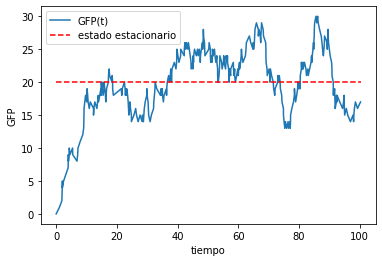

In [42]:
plt.plot(out[0], out[1])
plt.xlabel("tiempo")
plt.ylabel("GFP")
plt.plot(out[0], np.ones_like(out[0])*20, "r--")
plt.legend(["GFP(t)", "estado estacionario"])

## Obtener la concentración final de GFP al realizar varias simulaciones para determinar su distribución

In [46]:
def GFP_final(GFP0, tend):

    out = gillespieGFp(GFP0, tend)

    GFP = out[1]

    return GFP[-1] 

In [47]:
GFP_final(0, 100)

22

In [55]:
N = 1000
GFPs = []
for i in range(N):
    GFPs.append(GFP_final(0, 100))

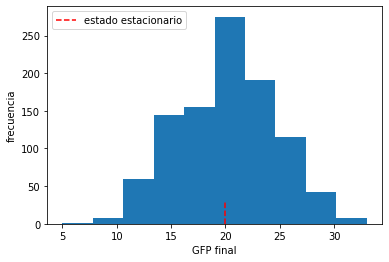

In [56]:
plt.hist(GFPs)
plt.plot([20, 20], [0, 30], "r--")
plt.xlabel("GFP final")
plt.ylabel("frecuencia")
plt.legend(["estado estacionario"])

## Simular con modelo determinista

In [58]:
# modelo del proceso
def modelo(s, t, p):
    GFP = s[0]
    p1 = p[0]
    k2 = p[1]
    dGFP = p1 - k2 * GFP
    return dGFP

In [59]:
# valor de parámetros 
p = [p1, k2]
# condiciones iniciales 
s = [0]
# tiempo de integración
t = np.linspace(0, 100, 1000)

In [61]:
# resolver el modelo
out = odeint(modelo, s, t, args = (p, ))

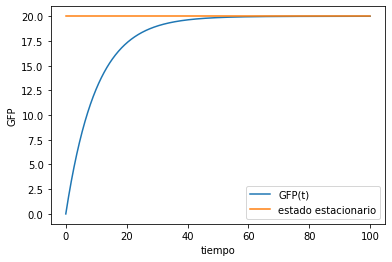

In [65]:
# mostrar resultados 
plt.plot(t, out)
plt.plot(t, np.ones_like(t) * 20)
plt.xlabel("tiempo")
plt.ylabel("GFP")
plt.plot(out[0], np.ones_like(out[0])*20, "r--")
plt.legend(["GFP(t)", "estado estacionario"])